In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from skimage.transform import resize

import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.optimizers import Adam
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras import backend as K

Using TensorFlow backend.


In [2]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [3]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [4]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [5]:
def print_roc_metrics(y_real, y_predict):

    c_matrix = confusion_matrix(y_real.ravel(), y_predict.ravel())
    f1 = f1_score(y_real.ravel(), y_predict.ravel())
    recall = recall_score(y_real.ravel(), y_predict.ravel())
    precision = precision_score(y_real.ravel(), y_predict.ravel())
    print("Confusion matrix:")
    print(c_matrix)
    print("F1 score: {:.4f}".format(f1))
    print("Recall score: {:.4f}".format(recall))
    print("Precision score: {:.4f}".format(precision))
    
    return c_matrix, f1, recall, precision

In [6]:
source_string =  'vertical' #'horizontal' #
receiver_string =  'combined' #'combined',  'das' 'geophone'
##foldstring = 2 #0, 1, or 2
##values4random_state=[1234, 69, 753]

In [7]:
if source_string == 'horizontal':
    data = np.load(r'./horizontal_data/h_'+receiver_string+'_data.npy') 
    labels = np.load(r'./horizontal_data/h_fault_labels.npy')
else:
    data = np.load(r'./vertical_data/v_'+receiver_string+'_data.npy')
    labels = np.load(r'./vertical_data/v_fault_labels.npy')

In [8]:
nx = 256
ny = 256

In [9]:
resized_data = np.zeros((len(data), nx, ny, 1))
resized_labels = np.zeros((len(data), nx, ny, 2))
for i in range(len(resized_data)):
    resized_data[i,:,:,0] = resize(data[i,:,:,0], (nx, ny))
    resized_labels[i,:,:,1] = resize(labels[i,:,:,0], (nx, ny))
    resized_labels[i,:,:,0] = resize(labels[i,:,:,1], (nx, ny))
resized_labels[resized_labels <= 0.5] = 0
resized_labels[resized_labels > 0.5] = 1

//anaconda/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [10]:
# Standardization across entire dataset
data_mean = np.mean(resized_data)
data_std = np.std(resized_data)
data_scaled = (resized_data-data_mean)/data_std

In [11]:
x = data_scaled
y = resized_labels[:,:,:,1]
y = np.expand_dims(y, axis=-1)

In [12]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, l2_lambda=5e-5, batch_norm=True):
    """
    A single convolution block for Unet.
    Convolution -> Batch Normalization -> Activation -> Repeat
    """
    # first layer
    conv_0 = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same", kernel_regularizer=regularizers.l2(l2_lambda))(input_tensor)
    if batch_norm:
        conv_0 = BatchNormalization()(conv_0)
    conv_0 = Activation("relu")(conv_0)
    # second layer
    conv_1 = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same", kernel_regularizer=regularizers.l2(l2_lambda))(conv_0)
    if batch_norm:
        conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    return conv_1

In [13]:
def create_unet(input_image, n_filters=16, dropout=0.5, batch_norm=True):
    """
    Create U-net similar to that described by Ronneberger et al. 2015, with some changes:
    Output size will equal input size for all convolutioin operations
    Dropout is applied after every max pooling or upconvolution operation.
    L2 regularization is applied after every convolution
    """
    # downsampling layers
    c_d_0 = conv2d_block(input_image, n_filters=n_filters, kernel_size=3, batch_norm=batch_norm)
    p_d_0 = MaxPooling2D((2,2))(c_d_0)
    d_d_0 = Dropout(dropout*0.5)(p_d_0)

    c_d_1 = conv2d_block(d_d_0, n_filters=n_filters*2, kernel_size=3, batch_norm=batch_norm)
    p_d_1 = MaxPooling2D((2,2))(c_d_1)
    d_d_1 = Dropout(dropout)(p_d_1)

    c_d_2 = conv2d_block(d_d_1, n_filters=n_filters*4, kernel_size=3, batch_norm=batch_norm)
    p_d_2 = MaxPooling2D((2,2))(c_d_2)
    d_d_2 = Dropout(dropout)(p_d_2)

    c_d_3 = conv2d_block(d_d_2, n_filters=n_filters*8, kernel_size=3, batch_norm=batch_norm)
    p_d_3= MaxPooling2D(pool_size=(2,2))(c_d_3)
    d_d_3 = Dropout(dropout)(p_d_3)
    
    c_d_4 = conv2d_block(d_d_3, n_filters=n_filters*16, kernel_size=3, batch_norm=batch_norm)
    
    # upsampling layers
    u_u_3 = Conv2DTranspose(n_filters*8, (3,3), strides=(2,2), padding='same')(c_d_4)
    # skip layer 3
    cc_u_3 = concatenate([u_u_3, c_d_3])
    d_u_3 = Dropout(dropout)(cc_u_3)
    c_u_3 = conv2d_block(d_u_3, n_filters=n_filters*8, kernel_size=3, batch_norm=batch_norm)

    u_u_2 = Conv2DTranspose(n_filters*4, (3,3), strides=(2,2), padding='same')(c_u_3)
    cc_u_2 = concatenate([u_u_2, c_d_2])
    # skip layer 2
    d_u_2 = Dropout(dropout)(cc_u_2)
    c_u_2 = conv2d_block(d_u_2, n_filters=n_filters*4, kernel_size=3, batch_norm=batch_norm)

    u_u_1 = Conv2DTranspose(n_filters*2, (3,3), strides=(2,2), padding='same')(c_u_2)
    # skip layer 1
    cc_u_1 = concatenate([u_u_1, c_d_1])
    d_u_1 = Dropout(dropout)(cc_u_1)
    c_u_1 = conv2d_block(d_u_1, n_filters=n_filters*2, kernel_size=3, batch_norm=batch_norm)

    u_u_0 = Conv2DTranspose(n_filters, (3,3), strides=(2,2), padding='same')(c_u_1)
    # skip layer 0
    cc_u_0 = concatenate([u_u_0, c_d_0], axis=3)
    d_u_0 = Dropout(dropout)(cc_u_0)
    c_u_0 = conv2d_block(d_u_0, n_filters=n_filters, kernel_size=3, batch_norm=batch_norm)
    
    output_segmentation = Conv2D(1, (1, 1), activation='sigmoid')(c_u_0)
    model = Model(inputs=[input_img], outputs=[output_segmentation])
    return model

In [14]:
# lists for holding statistics from CV
eval_stats = []
c_matrices = []
f1_stats = []
recall_stats = []
precision_stats = []

In [21]:
# reshaping y for kfolds.split (original shape still used for training)
y_reshaped = y.reshape((len(y), y.shape[1]*y.shape[2]))

# Perform K fold split for CV
Step 2. Change the ModelCheckpoint argument to name your models generated from each fold

In [ ]:
?KFold

In [15]:
kfolds = KFold(n_splits=3, shuffle=True, random_state=69) #random_state was not set for 1st CV of Horizontal DAS

In [16]:
# NameCheckpoint = 'models/'+source_string[0]+'-model-'+receiver_string+'-dice-fold-'#+str(foldstring)+'.h5'
NameCheckpoint = 'models/'+source_string[0]+'-model-'+receiver_string+'-fold'#+str(foldstring)+'.h5'
print(NameCheckpoint)

models/v-model-combined-fold


In [19]:
import time
t = time.time()
# do stuff
elapsed = time.time() - t
print('elapsed time',elapsed)

elapsed time 2.193450927734375e-05


In [17]:
## Load previous model?
LoadPrevious = 1

In [22]:
t = time.time()
for j, (train,val) in enumerate(kfolds.split(x, y_reshaped)):
    print('Training for fold {j}'.format(j=j))
    input_img = Input((nx, ny, 1), name='img')
    
    model = create_unet(input_img, n_filters=16, dropout=0.025, batch_norm=True)
    model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=["accuracy", f1])
    
    ## OLD MODEL Weights file HERE!!   
    if LoadPrevious == 1:
        #model.load_weights('./models/'+source_string[0]+'-model-geophone-fold-{i}_50epoch.h5'.format(i=j))
        # # MICHAEL'S WEIGHTS: VERTICAL ONLY
        model.load_weights('./models/model-'+receiver_string+'-dice-fold-{i}-keras.h5'.format(i=j))
        # #
        print("size of LOADED weights:",np.shape(model.get_weights()))
        print(model.get_weights()[0][0])
        
    ## NEW MODEL Weights file HERE!!    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
        ModelCheckpoint(NameCheckpoint+'-{i}_100epoch.h5'.format(i=j), verbose=1, save_best_only=True, save_weights_only=True)
    ]
    
    results = model.fit(x[train], y[train], batch_size=1, epochs=100, callbacks=callbacks,
                       validation_data=(x[val], y[val]))
    
    eval_stats.append(model.evaluate(x[val], y[val], verbose=1))    
    # Predict on train, val and test
    preds_val = model.predict(x[val], verbose=1)
    # Threshold predictions
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    # confusion matrix calculations
    c_matrix = confusion_matrix(y[val].ravel(), preds_val_t.ravel())
    f1_metric = f1_score(y[val].ravel(), preds_val_t.ravel())
    recall = recall_score(y[val].ravel(), preds_val_t.ravel())
    precision = precision_score(y[val].ravel(), preds_val_t.ravel())
    c_matrices.append(c_matrix)
    f1_stats.append(f1_metric)
    recall_stats.append(recall)
    precision_stats.append(precision)
    
elapsed = time.time() - t
print('elapsed time',elapsed)

Training for fold 0
size of LOADED weights: (118,)
[[[-0.28594556  0.06087189 -0.35679764  0.20312005 -0.01559232
    0.06216661  0.13975424  0.11081334  0.10477987  0.07890682
    0.29468048 -0.015343   -0.09282309  0.0760137   0.04808076
    0.26520285]]

 [[ 0.0941376   0.16903515 -0.00741779  0.20390736 -0.26758742
    0.04122241  0.05460102  0.25423115 -0.21888216  0.02384838
   -0.01416525  0.04251644  0.642405   -0.00795194  0.06827527
    0.02696223]]

 [[ 0.07195768 -0.32874587  0.30954933 -0.06390805  0.24363063
   -0.02802558  0.00417702 -0.32010344  0.22017239 -0.00659807
    0.3808607  -0.14013039  0.00654059 -0.08051324  0.05770043
    0.04404148]]]
Train on 122 samples, validate on 61 samples
Epoch 1/100
122/122 [==============================] - 94s 768ms/step - loss: 0.0054 - acc: 0.9925 - f1: 0.8616 - val_loss: 0.0048 - val_acc: 0.9930 - val_f1: 0.8496

Epoch 00001: val_loss improved from inf to 0.00485, saving model to models/v-model-combined-fold-0_100epoch.h5
Epoch

In [23]:
print(eval_stats)
print(c_matrices)
print(f1_stats)
print(recall_stats)
print(precision_stats)

[[0.0032651767050694736, 0.9949603432514629, 0.8967932628803565], [0.003087607678025961, 0.9949308203869178, 0.9114002683123604], [0.0034024900237678503, 0.9950241329240017, 0.9078158355150067]]
[array([[3885713,    6786],
       [  13361,   91836]]), array([[3874677,    8572],
       [  11693,  102754]]), array([[3877592,    8506],
       [  11386,  100212]])]
[0.9011524931434263, 0.9102417029494227, 0.9097115052923983]
[0.8729906746390106, 0.8978304367960716, 0.8979730819548738]
[0.9311918233254244, 0.9230009162280151, 0.9217608859618462]


In [24]:
c_matrices_stacked = np.rollaxis(np.dstack(c_matrices), axis=-1)
eval_stats = np.asarray(eval_stats)

In [25]:
np.shape(results.history["loss"])

(69,)

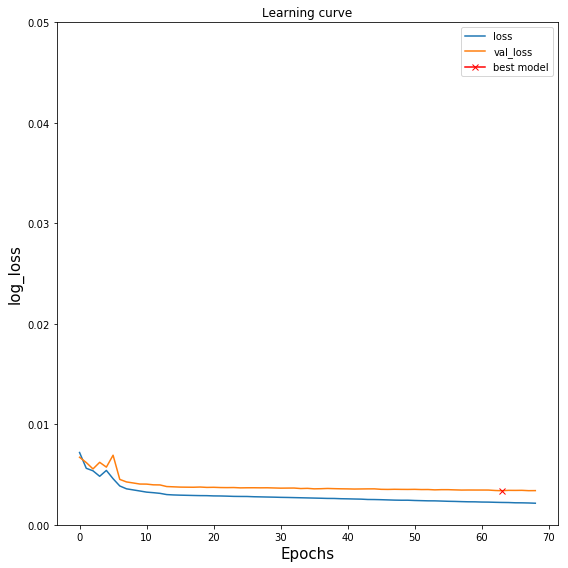

In [26]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
# plt.xlim([30,50])
plt.ylim([0,0.05])
# plt.rc('font', weight='bold')
# plt.yscale('log')
plt.rc('xtick.major', size=5, pad=7)
plt.rc('ytick.major', size=5, pad=7)
# plt.rc('xtick', labelsize=15)
plt.xlabel("Epochs", size=15)
plt.ylabel("log_loss", size=15)

plt.legend();
plt.tight_layout()
LossFigDir = '/Users/wtrainor/Library/Mobile Documents/com~apple~CloudDocs/Students/Samir/Geophysics/UNet/ArticleE/Fig/'
LossFigName = 'LossFunction'+source_string+'_'+receiver_string+'_100epoch.pdf'
plt.savefig(LossFigDir+LossFigName,dpi=800, bbox_inches='tight', transparent=True) #,format='ps')
plt.show()

In [27]:
np.savetxt('images_for_presentation_paper/'+source_string+'_'+receiver_string+'_Loss_100epochs.csv', np.asarray([results.history["loss"],results.history["val_loss"]]).T,
          delimiter=',', header='TrainingLoss, ValidationLoss', fmt='%f')

In [28]:
print(np.average(f1_stats))

0.9070352337950824


In [29]:
print(np.average(recall_stats))

0.8895980644633187


In [30]:
print(np.average(precision_stats))

0.9253178751717619


In [31]:
print(c_matrices_stacked[:,0,1])

[6786 8572 8506]


In [32]:
np.savetxt('images_for_presentation_paper/'+source_string+'_'+receiver_string+'_CV_metrics_100epochs.csv', np.asarray([np.arange(3), eval_stats[:,0], eval_stats[:,1], 
                                                  c_matrices_stacked[:,0,0], c_matrices_stacked[:,0,1],
                                                  c_matrices_stacked[:,1,0],c_matrices_stacked[:,1,1], 
                                                  f1_stats, recall_stats, precision_stats]).T,
          delimiter=',', header='Fold, Loss, Accuracy, True Negatives, False Positives, False Negatives, True Positives, F1-score'
          ', Recall, Precision', fmt='%f')